<a href="https://colab.research.google.com/github/ChoeTaeBin/deep_learning_study/blob/master/RNN_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

훈련용 데이터 생성  
(노이즈가 있는 sin함수)

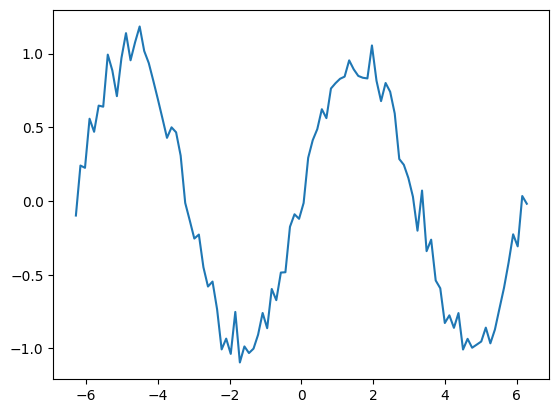

In [2]:
import math
import matplotlib.pyplot as plt

sin_x = torch.linspace(-2*math.pi, 2*math.pi, 100) #-2ㅠ부터 2ㅠ까지
sin_y = torch.sin(sin_x) + 0.1*torch.randn(len(sin_x)) #sin 함수에 sin 함수에 노이즈 더함
plt.plot(sin_x, sin_y)
plt.show()

앞의 10개 시각의 데이터를 이용해서 바로 다음 시각의 값을 예측 하는 것이 목표

In [6]:
from torch.utils.data import TensorDataset, DataLoader

n_time = 10 #시각 수
n_sample = len(sin_x)- n_time #샘플 수

input_data = torch.zeros((n_sample, n_time, 1)) #입력
correct_data = torch.zeros((n_sample, 1)) #정답

for i in range(n_sample):
  input_data[i] = sin_y[i:i+n_time].view(-1,1) #시각 0~9 까지가 input[0]이됨
  correct_data[i] = sin_y[i+n_time : i+n_time+1] #정답은 시각 10에서의 값

In [8]:
input_data.shape

torch.Size([90, 10, 1])

In [9]:
correct_data.shape

torch.Size([90, 1])

TensorDataset 인스턴스로 만들기

In [7]:
dataset = TensorDataset(input_data, correct_data) #데이터셋 작성

DataLoader 생성

In [12]:
train_loader = DataLoader(dataset, batch_size=8, shuffle = True)

모델 생성

In [17]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.RNN(
        input_size = 1, #입력 픽셀 수
        hidden_size = 64, #뉴런 수(출력 픽셀 수)
        batch_first = True #입력의 형태를 (batch_size, 시각의 수, 입력의 수) 로 한다.
    )
    self.fc = nn.Linear(64, 1)

  def forward(self, x):
    #y_rnn에는 모든 출력이 저장되고(batch크기 = 8, 시각 수 = 10, 출력 픽셀 수= 64), h에는 최후 은닉측 출력이 저장된다.
    y_rnn, h = self.rnn(x,None)
    y = self.fc(y_rnn[:, -1, : ]) #마지막 데이터 출력만 취함
    return y

In [29]:
net = Net()
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


optimizer, loss 생성

In [30]:
from torch import optim

loss_fnc = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

학습

Epoch:0, Loss_Train:0.5380098484456539


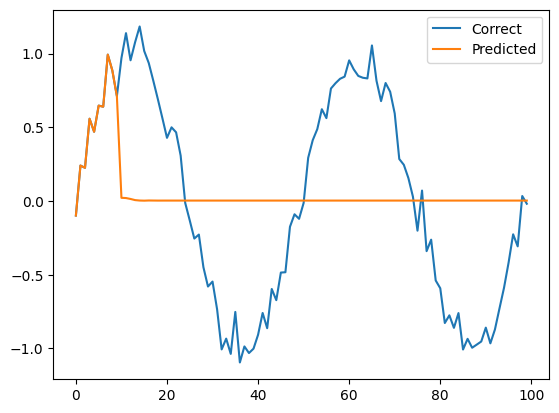

Epoch:10, Loss_Train:0.0480470786181589


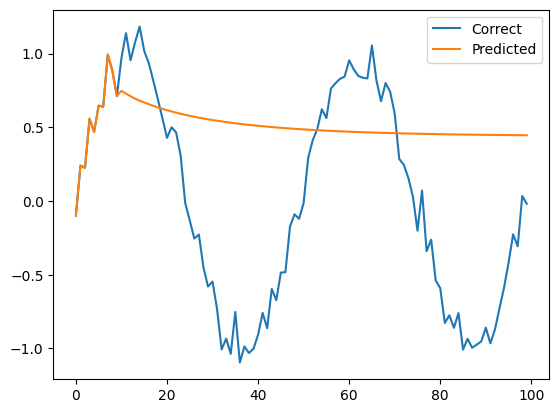

Epoch:20, Loss_Train:0.030114608351141214


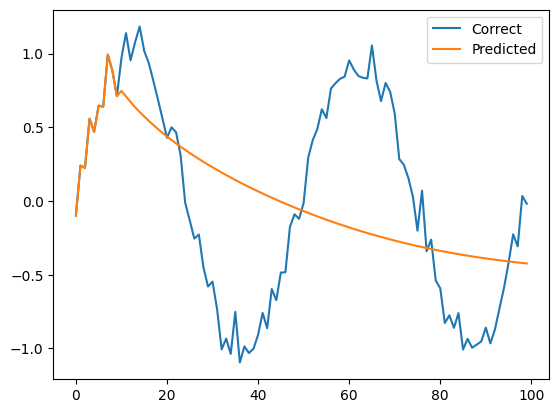

Epoch:30, Loss_Train:0.02327178492366026


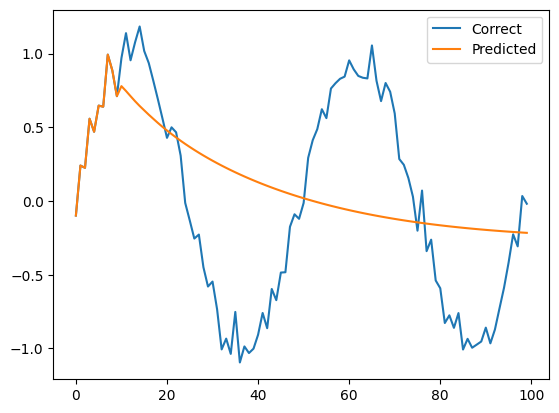

Epoch:40, Loss_Train:0.01936678363320728


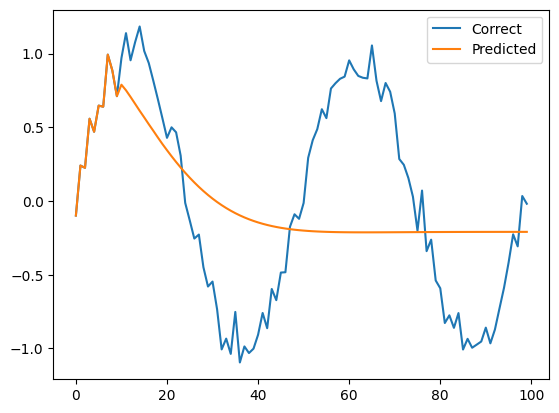

Epoch:50, Loss_Train:0.016083453587877255


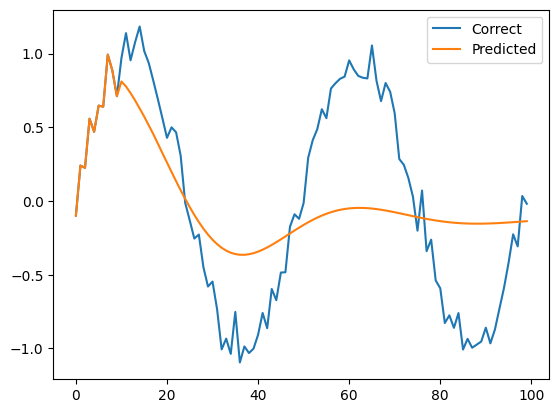

Epoch:60, Loss_Train:0.01576620355869333


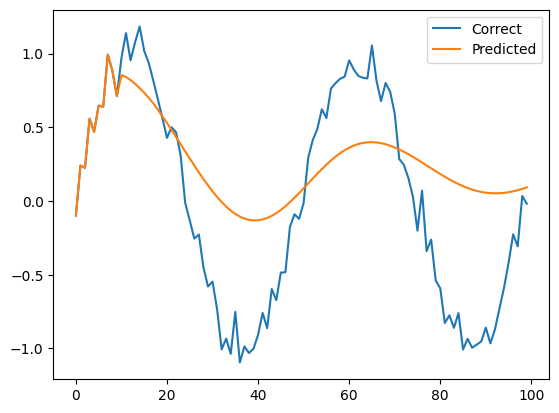

Epoch:70, Loss_Train:0.015726208803243935


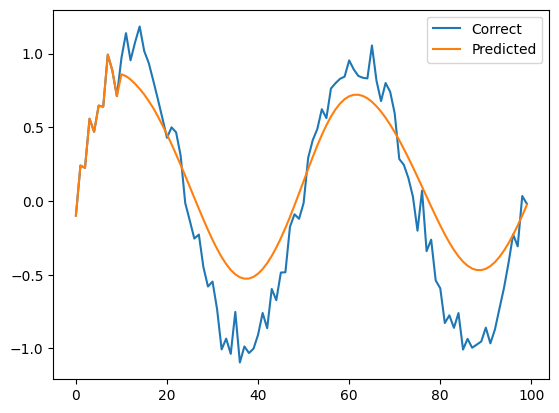

Epoch:80, Loss_Train:0.014820637103791038


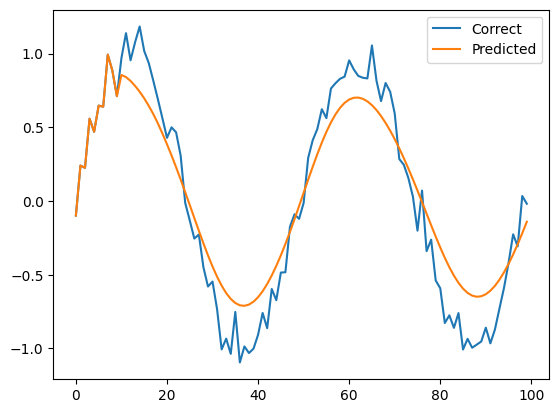

Epoch:90, Loss_Train:0.015122825823103389


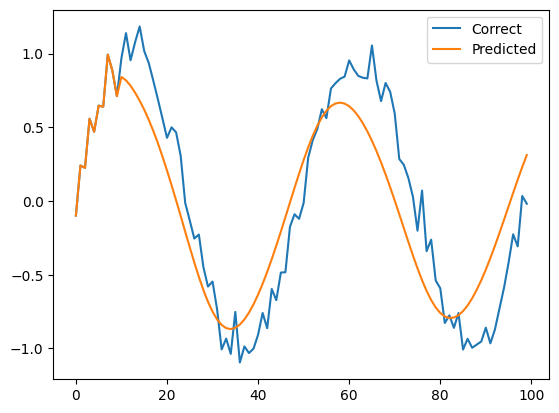

Epoch:99, Loss_Train:0.015014380488234261


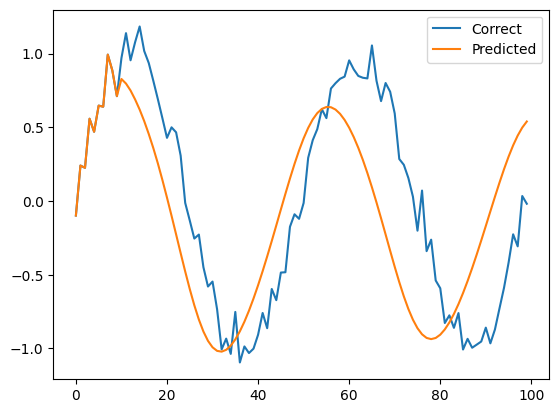

In [31]:
record_loss_train = []
num_epochs = 100

for i in range(num_epochs):
  net.train() #훈련 모드로
  loss_train = 0

  for j, (x,t) in enumerate(train_loader):
    y = net(x)
    loss = loss_fnc(y, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train += loss.item()

  loss_train /=j+1
  record_loss_train.append(loss_train)

  #10에프크 마다 예측 그래프를 그려보자
  if(i%10 == 0 or i == num_epochs-1):
    net.eval()
    print(f"Epoch:{i}, Loss_Train:{loss_train}")
    predicted = list(input_data[0].view(-1)) #초기 한칸의 time slice만으로 모든 예측을 만들어낼것(얘가 씨앗이다.)

    #예측(가장 최근의 타임 슬라이스를 가져와서 새로운 예측을 만듦 그런데 이전의 값들도 어짜피 내가 예측 한 것임)
    for k in range(n_sample):
      x = torch.tensor(predicted[-n_time : ])#가장 최근의 time_slice를 꺼낸다.
      x = x.view(1, n_time, 1) #batch_first == True라서 batch가 1인 상황으로 코드를 짜야함
      y = net(x)
      predicted.append(y[0].item()) #batch_first == True라서 batch가 1인 상황으로 코드를 짜야함

    plt.plot(range(len(sin_y)), sin_y, label = "Correct")
    plt.plot(range(len(predicted)), predicted, label = "Predicted")
    plt.legend()
    plt.show()

오차추이

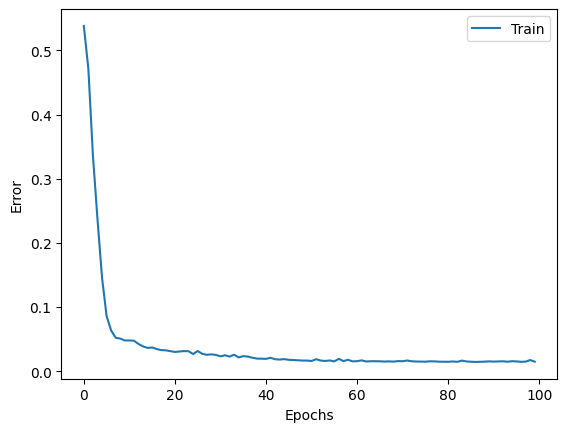

In [32]:
plt.plot(range(len(record_loss_train)), record_loss_train, label = "Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()